## 2023 Research Deep Residual

In [1]:
#import tools
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import datasets, layers, optimizers, Sequential, metrics
import matplotlib.pyplot as plt
from array import *
import random
from sklearn.model_selection import StratifiedKFold

2023-08-14 20:04:39.872391: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#import dataset & labels
x_data = np.loadtxt("/home/jovyan/SummerResearch/Data/CC400_X_corr.csv", delimiter = ',')
y_data = np.loadtxt("/home/jovyan/SummerResearch/Data/Y.csv", delimiter = ',')
x_data_sampled_train = np.empty((696,x_data.shape[1]))
x_data_sampled_val = np.empty((175,x_data.shape[1]))
y_data_sampled_train = np.empty(696)
y_data_sampled_val = np.empty(175)
type(x_data)
print(x_data.shape, x_data_sampled_train.shape)

(871, 77028) (696, 77028)


In [3]:
"""
#check for data normalization dynamic to the dimensions of the set
max = 0.0
min = 0.0
count = 0
temp = 0.0

for i in range(x_data.shape[0]):
    for j in range(x_data.shape[1]):
        temp = x_data[i][j]
        count += 1
        if temp > max:
            max = temp
        elif temp < min:
            min = temp

print("Checking for normalization of the data set...")
print("Max Value: {a:1.5f}".format(a = max))
print("Min Value: {a:1.5f}".format(a = min))
print("Elements Checked:", count)
"""

'\n#check for data normalization dynamic to the dimensions of the set\nmax = 0.0\nmin = 0.0\ncount = 0\ntemp = 0.0\n\nfor i in range(x_data.shape[0]):\n    for j in range(x_data.shape[1]):\n        temp = x_data[i][j]\n        count += 1\n        if temp > max:\n            max = temp\n        elif temp < min:\n            min = temp\n\nprint("Checking for normalization of the data set...")\nprint("Max Value: {a:1.5f}".format(a = max))\nprint("Min Value: {a:1.5f}".format(a = min))\nprint("Elements Checked:", count)\n'

In [4]:
#measure percent of positive vs negative samples in our set
true = 0
false = 0
true_rate = 0.0
false_rate = 0.0
#pos samples 403
#neg samples 468

for x in range(x_data.shape[0]):
    if y_data[x] == 1: 
        true += 1
    else:
        false += 1
    
true_rate = true/(true+false) * 100
false_rate = false/(true+false) * 100

print("Distribution of Subgroups in Population...")
print("ASD Positive: {a:2.2f}%".format(a = true_rate), true)
print("ASD Negative: {a:2.2f}%".format(a = false_rate), false)

Distribution of Subgroups in Population...
ASD Positive: 46.27% 403
ASD Negative: 53.73% 468


In [5]:
def stratifiedRandomSampling():
    X = x_data
    y = y_data
    num_splits = 5
    skf = StratifiedKFold(n_splits = num_splits, shuffle = True)
    skf.get_n_splits(X, y)
    skf = list(skf.split(X, y))
    print(len(skf), len(skf[0]), len(skf[0][0]))
    #for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        #print(f"Fold {i}:")
        #print(f"  Train: index={train_index}")
        #print(f"  Test:  index={test_index}")
        
    #train_index[696], test_index[175] = enumerate(skf.split(X, y))
    
    for x in range (696):
        target = skf[0][0][x]
        for y in range(x_data.shape[1]):
            x_data_sampled_train[x][y] = x_data[target][y]
        y_data_sampled_train[x] = y_data[target]
    for x in range (175):
        target = skf[0][1][x]
        for y in range(x_data.shape[1]):
            x_data_sampled_val[x][y] = x_data[target][y]
        y_data_sampled_val[x] = y_data[target]
        
    #y_data_sampled_train
    
    return
    

In [6]:
def modelConstructor(n_hidden_units, n_hidden_layers):
    y = x = keras.layers.Input(shape=x_data_sampled_train.shape[1:])
    y = keras.layers.Flatten()(y)
    y = keras.layers.Dense(n_hidden_units)(y)
    for _ in range(n_hidden_layers):
        y_resid = y
        y = keras.layers.LayerNormalization()(y)
        y = keras.layers.Dense(n_hidden_units,
                               activation=keras.activations.relu)(y)
        y = keras.layers.Add()([y,y_resid])
    y = keras.layers.Dense(len(np.unique(y_data_sampled_train)),
                               activation=keras.activations.softmax)(y)
    model = keras.Model(x,y)
    model.summary()
    keras.utils.plot_model(model,show_shapes=True,expand_nested=True)
    model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=keras.metrics.SparseCategoricalAccuracy(),
    optimizer=keras.optimizers.SGD(learning_rate=0.002))
    return model

In [7]:
"""
epochs:         20
learning rate:  0.001
hidden units:   2
hidden layers:  2
batch size:     16
Training Loss Average: 0.34587
Training Accuracy Average: 91.09%
Validation Loss Average: 0.60430
Validation Accuracy Average: 67.42857%

epochs:         20
learning rate:  0.0015
hidden units:   2
hidden layers:  2
batch size:     16
Training Loss Average: 0.57873
Training Accuracy Average: 76.15%
Validation Loss Average: 0.64881
Validation Accuracy Average: 60.57143%

epochs:         20
learning rate:  0.002
hidden units:   2
hidden layers:  2
batch size:     16
Training Loss Average: 0.33350
Training Accuracy Average: 86.64%
Validation Loss Average: 0.63834
Validation Accuracy Average: 66.28571%

epochs:         50
learning rate:  0.001
hidden units:   2
hidden layers:  2
batch size:     32
Training Loss Average: 0.16432
Training Accuracy Average: 96.84%
Validation Loss Average: 0.58706
Validation Accuracy Average: 73.71429%

epochs:         50
learning rate:  0.002
hidden units:   4
hidden layers:  4
batch size:     32
Training Loss Average: 0.13980
Training Accuracy Average: 97.84%
Validation Loss Average: 0.53553
Validation Accuracy Average: 77.14286%

epochs:         50
learning rate:  0.002
hidden units:   4
hidden layers:  4
batch size:     32
Training Loss Average: 0.19247
Training Accuracy Average: 93.39%
Validation Loss Average: 0.67157
Validation Accuracy Average: 66.28571%

epochs:         50
learning rate:  0.002
hidden units:   4
hidden layers:  4
batch size:     32
Training Loss Average: 0.37791
Training Accuracy Average: 87.93%
Validation Loss Average: 0.65961
Validation Accuracy Average: 67.42857%

epochs:         50
learning rate:  0.002
hidden units:   4
hidden layers:  4
batch size:     32
Training Loss Average: 0.01198
Training Accuracy Average: 100.00%
Validation Loss Average: 0.94252
Validation Accuracy Average: 63.42857%

"""

'\nepochs:         20\nlearning rate:  0.001\nhidden units:   2\nhidden layers:  2\nbatch size:     16\nTraining Loss Average: 0.34587\nTraining Accuracy Average: 91.09%\nValidation Loss Average: 0.60430\nValidation Accuracy Average: 67.42857%\n\nepochs:         20\nlearning rate:  0.0015\nhidden units:   2\nhidden layers:  2\nbatch size:     16\nTraining Loss Average: 0.57873\nTraining Accuracy Average: 76.15%\nValidation Loss Average: 0.64881\nValidation Accuracy Average: 60.57143%\n\nepochs:         20\nlearning rate:  0.002\nhidden units:   2\nhidden layers:  2\nbatch size:     16\nTraining Loss Average: 0.33350\nTraining Accuracy Average: 86.64%\nValidation Loss Average: 0.63834\nValidation Accuracy Average: 66.28571%\n\nepochs:         50\nlearning rate:  0.001\nhidden units:   2\nhidden layers:  2\nbatch size:     32\nTraining Loss Average: 0.16432\nTraining Accuracy Average: 96.84%\nValidation Loss Average: 0.58706\nValidation Accuracy Average: 73.71429%\n\nepochs:         50\n

In [8]:
skf = stratifiedRandomSampling()

5 2 696


In [9]:
y_data_sampled_val

array([1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0.,
       0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 1., 1., 1.])

In [10]:
counter_train = 0
counter_val = 0

for x in range(y_data_sampled_train.shape[0]):
    if y_data_sampled_train[x] == 1:
        counter_train += 1

for x in range(y_data_sampled_val.shape[0]):
    if y_data_sampled_val[x] == 1:
        counter_val += 1

print("Positive Training Count: ", counter_train)
print("Negative Training Count: ", 696-counter_train)
print("Positive Validation Count: ", counter_val)
print("Negative Validation Count: ", 175-counter_val)

Positive Training Count:  322
Negative Training Count:  374
Positive Validation Count:  81
Negative Validation Count:  94


Iteration: 0
5 2 696


2023-08-14 20:07:40.027910: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-08-14 20:07:40.027960: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-14 20:07:40.027994: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-hwb2i): /proc/driver/nvidia/version does not exist
2023-08-14 20:07:40.028364: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 77028)]      0           []                               
                                                                                                  
 flatten (Flatten)              (None, 77028)        0           ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 16)           1232464     ['flatten[0][0]']                
                                                                                                  
 layer_normalization (LayerNorm  (None, 16)          32          ['dense[0][0]']                  
 alization)                                                                                   

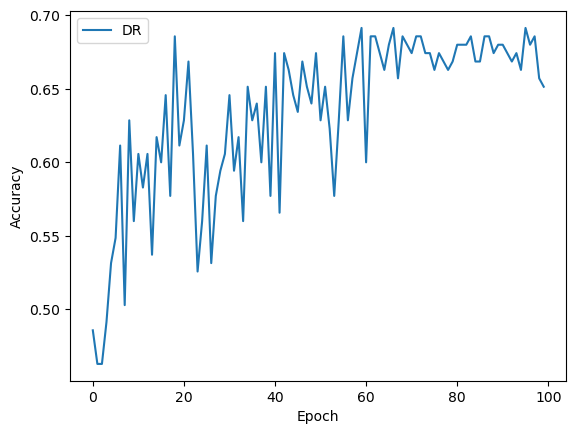

6/6 [==============================] - 1s 6ms/step
Iteration: 1
5 2 696
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 77028)]      0           []                               
                                                                                                  
 flatten_1 (Flatten)            (None, 77028)        0           ['input_2[0][0]']                
                                                                                                  
 dense_18 (Dense)               (None, 16)           1232464     ['flatten_1[0][0]']              
                                                                                                  
 layer_normalization_16 (LayerN  (None, 16)          32          ['dense_18[0][0]']               
 ormalization)      

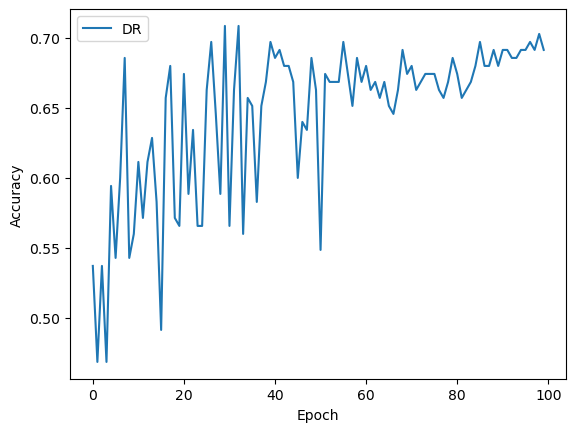

6/6 [==============================] - 1s 7ms/step
Iteration: 2
5 2 696
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 77028)]      0           []                               
                                                                                                  
 flatten_2 (Flatten)            (None, 77028)        0           ['input_3[0][0]']                
                                                                                                  
 dense_36 (Dense)               (None, 16)           1232464     ['flatten_2[0][0]']              
                                                                                                  
 layer_normalization_32 (LayerN  (None, 16)          32          ['dense_36[0][0]']               
 ormalization)      

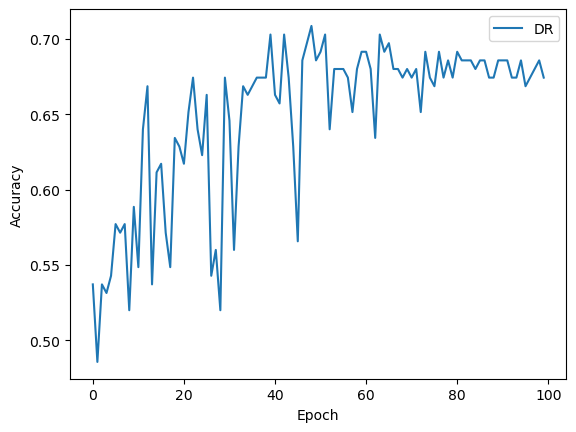

6/6 [==============================] - 1s 7ms/step
Iteration: 3
5 2 696
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 77028)]      0           []                               
                                                                                                  
 flatten_3 (Flatten)            (None, 77028)        0           ['input_4[0][0]']                
                                                                                                  
 dense_54 (Dense)               (None, 16)           1232464     ['flatten_3[0][0]']              
                                                                                                  
 layer_normalization_48 (LayerN  (None, 16)          32          ['dense_54[0][0]']               
 ormalization)      

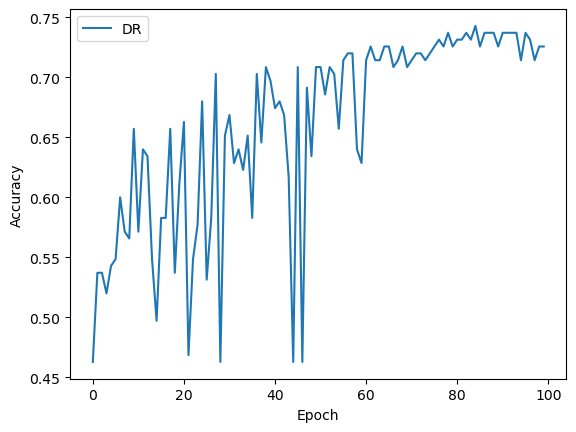

6/6 [==============================] - 1s 6ms/step
Iteration: 4
5 2 696
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 77028)]      0           []                               
                                                                                                  
 flatten_4 (Flatten)            (None, 77028)        0           ['input_5[0][0]']                
                                                                                                  
 dense_72 (Dense)               (None, 16)           1232464     ['flatten_4[0][0]']              
                                                                                                  
 layer_normalization_64 (LayerN  (None, 16)          32          ['dense_72[0][0]']               
 ormalization)      

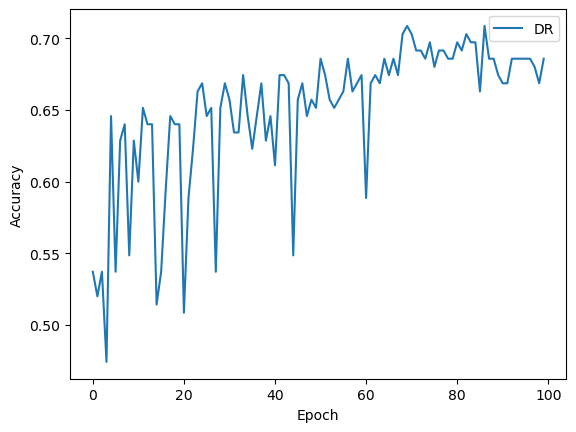

6/6 [==============================] - 1s 7ms/step


In [11]:
correct = 0
total = 175
labels_accuracy = 0.0
labels_accuracy_storage = np.empty(10,dtype=float)
results = np.empty((10,4), dtype=float)

#10 times cross validation
for x in range(5):
    print("Iteration:", x)
    stratifiedRandomSampling()
    model = modelConstructor(16,16)
    history = model.fit(x_data_sampled_train, y_data_sampled_train,
                epochs=100,
                verbose=2,
                batch_size=32,
                validation_data=(x_data_sampled_val,y_data_sampled_val))
    
    loss = history.history['loss']
    accuracy = history.history['sparse_categorical_accuracy']
    val_loss = history.history['val_loss']
    val_accuracy = history.history['val_sparse_categorical_accuracy']
    plt.plot(history.history["val_sparse_categorical_accuracy"],label="DR")
    #plt.plot(wide_history.history["val_sparse_categorical_accuracy"],label="Wide")
    #plt.plot(deep_history.history["val_sparse_categorical_accuracy"],label="Deep")
    plt.legend()
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.show()
    
    #get final results using last indexes
    results[x][0] = loss[-1]
    results[x][1] = accuracy[-1]
    results[x][2] = val_loss[-1]
    results[x][3] = val_accuracy[-1]
    
    output = model.predict(x_data_sampled_val[0:])
    np.argmax(output,axis=1)
    
    correct = 0
    
    for b in range(175):
        temp1 = output[b][0]
        temp2 = y_data_sampled_val[b]
        if temp1 == temp2:
            correct += 1
    
    labels_accuracy = correct/total
    labels_accuracy_storage[x] = labels_accuracy

In [12]:
loss_avg = 0.0
accuracy_avg = 0.0
val_loss_avg = 0.0
val_accuracy_avg = 0.0
labels_accuracy_avg = 0.0

for a in range(10):
    loss_avg += results[x][0]
for a in range(10):
    accuracy_avg += results[x][1]
for a in range(10):
    val_loss_avg += results[x][2]
for a in range(10):
    val_accuracy_avg += results[x][3]
    
loss_avg = loss_avg / 10
accuracy_avg = accuracy_avg / 10 * 100
val_loss_avg = val_loss_avg / 10
val_accuracy_avg = val_accuracy_avg / 10 * 100

for a in range(10):
    labels_accuracy_avg += labels_accuracy_storage[a]
    
labels_accuracy_avg = labels_accuracy_avg / 10 * 100

print("Training Loss Average: {a:1.5f}".format(a = loss_avg))
print("Training Accuracy Average: {a:1.2f}%".format(a = accuracy_avg))
print("Validation Loss Average: {a:1.5f}".format(a = val_loss_avg))
print("Validation Accuracy Average: {a:1.5f}%".format(a = val_accuracy_avg))
print("Label Accuracy Average: {a:1.2f}%".format(a = labels_accuracy_avg))

Training Loss Average: 0.00271
Training Accuracy Average: 100.00%
Validation Loss Average: 1.20114
Validation Accuracy Average: 68.57143%
Label Accuracy Average: 0.00%
